# Healthy Communities Data and Indicators Project (HCI)

Healthy Communities Data and Indicators Project (HCI)


In [1]:
from ambry import get_library
l = get_library()
b = l.bundle('cdph.ca.gov-hci-0.0.2')

First, create a set of views to limit the individual indicators to one record per county. The Ambry SQL parser is 
ver simplistic, and can't handle anything mroe then very simple joins. 

In [2]:
w = b.warehouse('hci_counties')
w.clean()
print w.dsn
w.query("""

-- Get only counties in California
CREATE VIEW geo AS SELECT gvid, name AS county_name,  geometry FROM census.gov-tiger-2015-counties
WHERE statefp = 6;

-- Get only records for all race/ethinicities
CREATE VIEW hf_total AS SELECT gvid, mrfei FROM cdph.ca.gov-hci-healthy_food-county
WHERE race_eth_name = 'Total';

-- Get only records for all race/ethinicities
CREATE VIEW aq_total AS SELECT gvid, pm25_concentration FROM cdph.ca.gov-hci-air_quality-county
WHERE race_eth_name = 'Total';

-- THe overty table has a lot of otrher categories, for report year and type of poverty
CREATE VIEW pr_total AS SELECT gvid, percent FROM  cdph.ca.gov-hci-poverty_rate-county
WHERE race_eth_name = 'Total' AND reportyear='2008-2010' AND poverty='Overall';

""").close()

sqlite://///Users/eric/proj/virt/ambry-develop/data/build/cdph.ca.gov/hci-0.0.2/warehouses/hci_counties.db


Now we can run a query to join the indicators. 

In [3]:
sql="""
SELECT county_name, mrfei, pm25_concentration, percent as percent_poverty FROM geo as counties
JOIN hf_total ON hf_total.gvid = counties.gvid
JOIN aq_total ON aq_total.gvid = counties.gvid
JOIN pr_total ON pr_total.gvid = counties.gvid;
"""

df = w.dataframe(sql)
df.head()


Failed to index geo; No partition for ref: 'geo'


,county_name,mrfei,pm25_concentration,percent_poverty
0,Sacramento,9.662819,10.599027,15.3
1,Santa Barbara,21.554555,7.505746,14.9
2,Calaveras,17.626020,8.578310,7.8
3,Ventura,15.337611,10.433785,9.8
4,Los Angeles,11.259910,13.713157,16.3


In [4]:
df.corr()

,mrfei,pm25_concentration,percent_poverty
mrfei,1.000000,-0.565976,-0.078721
pm25_concentration,-0.565976,1.000000,0.359692
percent_poverty,-0.078721,0.359692,1.000000


Plot the PM2.5 Concentration, [a measure of particulate air polution](http://www3.epa.gov/pmdesignations/faq.htm#0).

Failed to index geo; No partition for ref: 'geo'


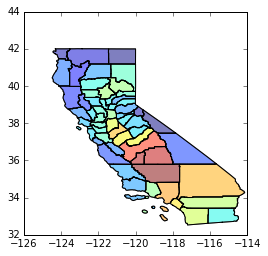

In [5]:
%matplotlib inline
sql="""
SELECT county_name, mrfei, pm25_concentration, percent as percent_poverty, geometry FROM geo as counties
LEFT JOIN hf_total ON hf_total.gvid = counties.gvid
LEFT JOIN aq_total ON aq_total.gvid = counties.gvid
LEFT JOIN pr_total ON pr_total.gvid = counties.gvid;
"""

w.geoframe(sql).plot(column='pm25_concentration')